In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
from implementations import *
from proj1_helpers import *

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

### Process missing data

In [4]:
missing_values_row_indices = np.where(tX == -999)
print("Total number of missing values:", missing_values_row_indices[0].shape[0])
print("Number of rows with >=1 missing value:", np.unique(missing_values_row_indices).shape[0])

Total number of missing values: 1580052
Number of rows with >=1 missing value: 181891


In [5]:
# Find features with missing values
missing_values_feature_indices = np.vstack([np.argwhere(row == -999) for row in tX])
unique_values, occur_count = np.unique(missing_values_feature_indices, return_counts=True)
missing_values_count_perfeature = {feature_ind: feature_count for feature_ind, feature_count in zip(unique_values, occur_count)}

for feature_ind in unique_values:
    print("{:25} (feature ind={:2}) missing {:7} values".format(
        feature_names[feature_ind], feature_ind, missing_values_count_perfeature[feature_ind]))

DER_mass_MMC              (feature ind= 0) missing   38114 values
DER_deltaeta_jet_jet      (feature ind= 4) missing  177457 values
DER_mass_jet_jet          (feature ind= 5) missing  177457 values
DER_prodeta_jet_jet       (feature ind= 6) missing  177457 values
DER_lep_eta_centrality    (feature ind=12) missing  177457 values
PRI_jet_leading_pt        (feature ind=23) missing   99913 values
PRI_jet_leading_eta       (feature ind=24) missing   99913 values
PRI_jet_leading_phi       (feature ind=25) missing   99913 values
PRI_jet_subleading_pt     (feature ind=26) missing  177457 values
PRI_jet_subleading_eta    (feature ind=27) missing  177457 values
PRI_jet_subleading_phi    (feature ind=28) missing  177457 values


Explanation of missing values from the documenation ("Learning to discover: the Higgs
boson machine learning challenge"):
* DER_mass_MMC: May be undefined if the topology of the event is too far from the expected topology
* DER_deltaeta_jet_jet: Undefined if PRI_jet_num ≤ 1
* DER_mass_jet_jet: Undefined if PRI_jet_num ≤ 1
* DER_prodeta_jet_jet: Undefined if PRI_jet_num ≤ 1
* DER_lep_eta_centrality: Undefined if PRI_jet_num ≤ 1
* PRI_jet_leading_pt: Undefined if PRI_jet_num = 0
* PRI_jet_leading_eta: Undefined if PRI_jet_num = 0
* PRI_jet_leading_phi: Undefined if PRI_jet_num = 0
* PRI_jet_subleading_pt: Undefined if PRI_jet_num ≤ 1
* PRI_jet_subleading_eta: Undefined if PRI_jet_num ≤ 1
* PRI_jet_subleading_phi: Undefined if PRI_jet_num ≤ 1

PRI_jet_num is feature 22

#### Draw features histigram

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [7]:
def plot_feature_hist(feature_ind, drop_nan):
    values = tX[:, feature_ind]
    if drop_nan:
        values = values[values != -999]
    plt.hist(values, bins=100)
    
interact(plot_feature_hist, 
         feature_ind=widgets.BoundedIntText(value=0, min=0, max=30, step=1, description='Feature index:', disabled=False), 
         drop_nan=widgets.Checkbox(value=False, description='Drop missing values', disabled=False)
        )

interactive(children=(BoundedIntText(value=0, description='Feature index:', max=30), Checkbox(value=False, des…

<function __main__.plot_feature_hist(feature_ind, drop_nan)>

#### Compute features correlation

In [8]:
rows_without_missing_data = list(set(range(250000)) - set(np.unique(missing_values_row_indices)))
tX_without_rows_with_missing_data = tX[rows_without_missing_data, :]
y_without_rows_with_missing_data = y[rows_without_missing_data]

In [9]:
# Compute correlation of features in dataset without missing data
n_features = tX_without_rows_with_missing_data.shape[1]
corr_matrix = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(i, n_features):
        corr_matrix[i, j] = corr_matrix[j, i] = np.corrcoef(tX_without_rows_with_missing_data[:, i], 
                                                            tX_without_rows_with_missing_data[:, j])[0,1]

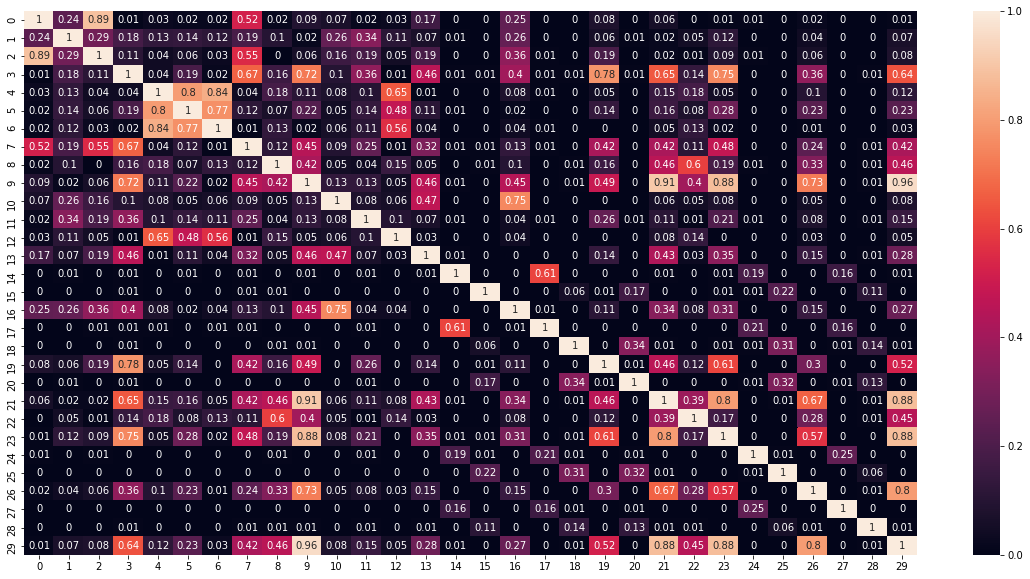

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(np.abs(np.round(corr_matrix, decimals=2)),annot=True)

#### Handle missing values

### Make same number of objects in data representing different classes

## Train

In [41]:
x_tr, y_tr, x_te, y_te = split_data(tX, y, ratio=0.8, seed=1)

In [42]:
def compare_regression_methods(x_tr, y_tr, x_te, y_te):
    w_initial = np.array([0] * tX.shape[1])
    max_iters = 30
    gamma = 0.001
    lambda_ = 1

    w_GD, _ = least_squares_GD(y_tr, x_tr, w_initial, max_iters, gamma)
    w_SGD, _ = least_squares_SGD(y_tr, x_tr, w_initial, max_iters, gamma)
    w_LS, _ = least_squares(y_tr, x_tr)
    w_RG, _ = ridge_regression(y_tr, x_tr, lambda_)

    methods = ["GD", "SGD", "LS", "RG"]
    weights = [w_GD, w_SGD, w_LS, w_RG]
    losses_tr = [compute_loss(y_tr, x_tr, w) for w in weights]
    losses_te = [compute_loss(y_te, x_te, w) for w in weights]
    accs = [compute_accuracy(y_te, predict_labels(w, x_te)) for w in weights]
    for i, method in enumerate(methods):
        print("Method: {:5}, train loss: {:5}, test loss: {:5}, test accuracy: {:5}".format(
            methods[i], losses_tr[i], losses_te[i], accs[i]))

### Baseline - Using all dataset

In [43]:
compare_regression_methods(x_tr, y_tr, x_te, y_te)

Method: GD   , train loss: 1.9213019551875894e+224, test loss: 1.9246799889273148e+224, test accuracy: 0.3692
Method: SGD  , train loss: 1.0868930601138387e+196, test loss: 1.0908043229414342e+196, test accuracy: 0.4693
Method: LS   , train loss: 0.3394, test loss: 0.3408, test accuracy: 0.744
Method: RG   , train loss: 0.3394, test loss: 0.3408, test accuracy: 0.744


### 1. Drop rows with missing values

### 2. Drop features with missing values

### 3. Use combination of models trained on different data

### 4. TODO

### 5. Transfer learning analogue

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)